In [49]:
import pm4py
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
import numpy as np
import tqdm

Load dataset with pickle

In [2]:
log = None
with open("data/log_pm4py.pkl", "rb") as f:
    log = pickle.load(f)
log_df = pm4py.convert_to_dataframe(log)


#### Initial activities:
* Renaming columns
* Counting activities and cases
* Identifying start and end activities 
* Number of missing value for each column

In [53]:
log_df.rename(columns={'Case ID': 'case:concept:name', 'Complete Timestamp': 'time:timestamp', 'Activity': 'concept:name', 'Resource': 'org:resource'}, inplace=True) #change the name to a colum

num_events = len(log_df)
num_cases = len(log_df['case:concept:name'].unique())

start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)

print("Number of events: ", num_events)
print("Number of cases: ", num_cases)
print("Start activities: ", start_activities)
print("End activities: ", end_activities)

missing_counts = log_df.isnull().sum()
print('Count missing values in each column: ')
print(missing_counts)

Number of events:  561470
Number of cases:  150370
Start activities:  {'Create Fine': 150370}
End activities:  {'Send Fine': 20755, 'Send for Credit Collection': 58997, 'Payment': 67201, 'Send Appeal to Prefecture': 3144, 'Appeal to Judge': 134, 'Notify Result Appeal to Offender': 86, 'Receive Result Appeal from Prefecture': 53}
Count missing values in each column: 
amount                  331240
org:resource            410545
dismissal               406404
concept:name                 0
vehicleClass            411100
totalPaymentAmount      333499
lifecycle:transition         0
time:timestamp               0
article                 411100
points                  411100
case:concept:name            0
expense                 457483
notificationType        481610
lastSent                483241
paymentAmount           483869
matricola               560915
dtype: int64


# Functions

### Function to plot a CDF of a given list

In [12]:
def plot_cdf(data, img_path=None, title='Cumulative Distribution Function (CDF)', xlabel='Data', ylabel='CDF'):
 
    data_sorted = np.sort(data)
    
    cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(data_sorted, cdf, marker='.', linestyle='-', color='b', label='CDF')
    

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    

    points_of_interest = [np.percentile(data_sorted, q) for q in [50]]
    for point in points_of_interest:
        ax.axvline(point, color='r', linestyle='--', linewidth=1)
        ax.text(point, 0.5, f'{point:.2f}', color='r', ha='center', fontsize=12, 
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))
    
    # Aggiungi la legenda
    ax.legend()
    
    # Mostra o salva il plot
    if img_path:
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()

# Filtering



## Duration based filtering

### Distribution of duration

Case duration for all cases.

Duration expressed in days.

In [83]:

case_durations = log_df.groupby('case:concept:name').agg( Events=('case:concept:name','count') ,
                                                          FirstOccurence =('time:timestamp', lambda x:x.min()),
                                                          LastOccurence =('time:timestamp', lambda x:x.max()),
                                                          Duration =('time:timestamp', lambda x: x.max()-x.min()))

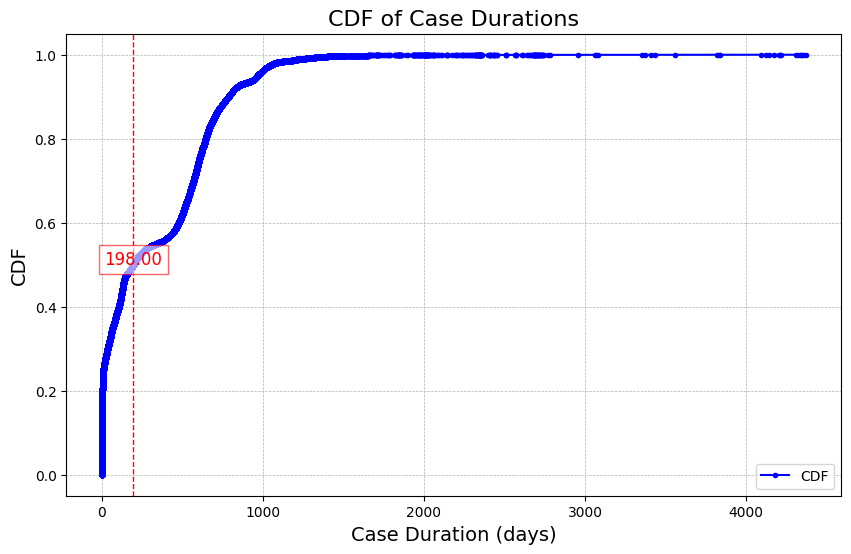

In [84]:
plot_cdf(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60)
, img_path="img/case_durations_cdf.png", title='CDF of Case Durations', xlabel='Case Duration (days)', ylabel='CDF')

Min max duration

In [85]:
#print min and max case duration
print(f"Min case duration: {case_durations['Duration'].min()}")
print(f"Max case duration: {case_durations['Duration'].max()}")

Min case duration: 0 days 00:00:00
Max case duration: 4372 days 00:00:00


In [86]:
#num of case with duration = 0
print(f"Number of cases with duration = 0: {case_durations[case_durations['Duration'] == pd.Timedelta(0)].shape[0]}")

Number of cases with duration = 0: 4920


### We now focus on cases with duration = 0

Filtering those 4920 cases with PMTK we get this sunburst plot

<img src="img/variants_sunburst.png" width="50%">

As we can see 98% of cases follow the same trace, create_fine -> payment, we can consider this cases as "manually" resolved by an operator. But since we cannot extract any information about the process we can discard this cases, as well for the 2% remaining that we just mark as noise.

After removing those cases we are left with <strong>145450 cases </strong>



145450


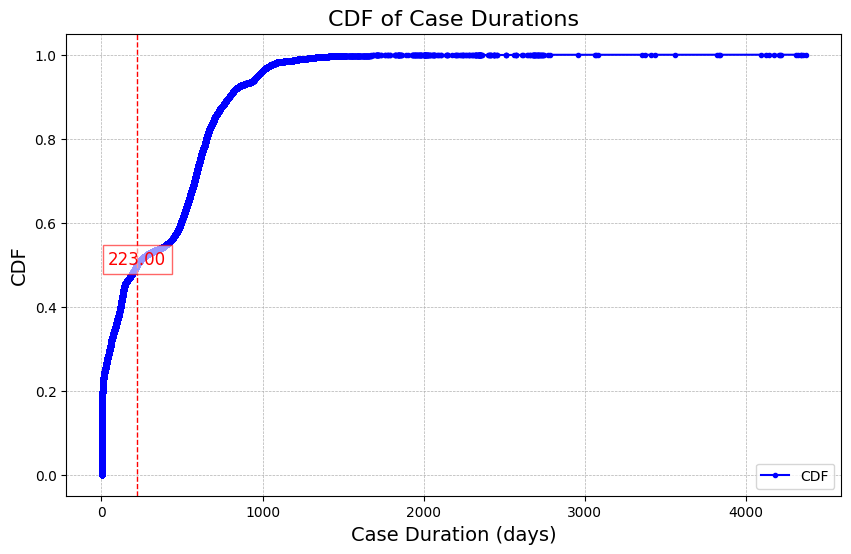

In [90]:
#remove all cases with duration = 0
case_durations = case_durations[case_durations['Duration'] > pd.Timedelta(0)]

#plot the cdf of the case duration
plot_cdf(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60)
, img_path="img/case_durations_over_0cdf.png", title='CDF of Case Durations', xlabel='Case Duration (days)', ylabel='CDF')

print(len(case_durations))

Looking at this plot we can see that aboout 20% of cases are close to zero, so we now focus on those

25th percentile: 23.0


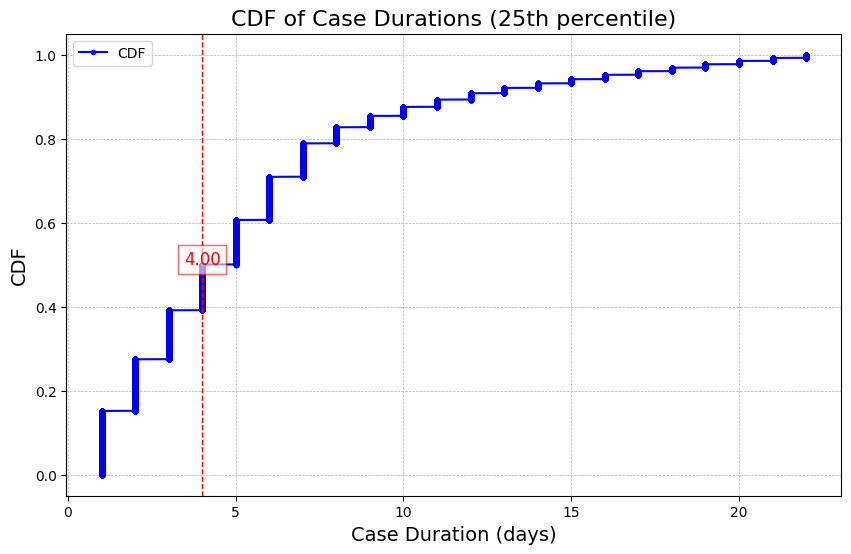

In [88]:
#get the 25 percentile
percentile_25 = np.percentile(case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60), 25)
print(f"25th percentile: {percentile_25}")

#get cases with duration < 25th percentile
p25_cases = case_durations[case_durations['Duration'].dt.total_seconds() / (24 * 60 * 60) < percentile_25]

plot_cdf(p25_cases['Duration'].dt.total_seconds() / (24 * 60 * 60), title='CDF of Case Durations (25th percentile)', xlabel='Case Duration (days)', ylabel='CDF')


From this plot we can see that half of the short_cases are resolved within four days. That are exactly (145450 * 0.25 * 0.5) = 18181 cases